In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        #     Steps:
        #       1) Transposed convolution using the given parameters.
        #       2) Batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) At the final layer, Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [4]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


In [6]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [7]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [8]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


In [9]:
# Set training parameters
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# Tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 0.9335291180610655, discriminator loss: 0.5123015542030345


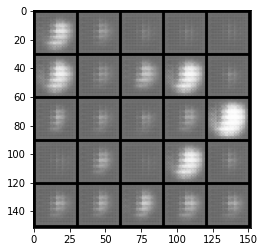

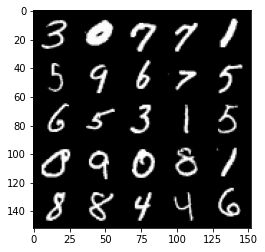

Step 1000: Generator loss: 1.45267070877552, discriminator loss: 0.4337931073904038


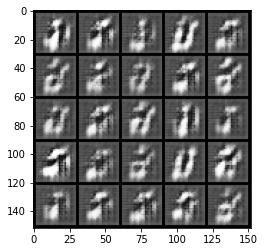

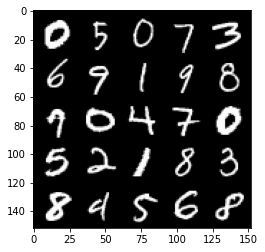

Step 1500: Generator loss: 1.2090378565192226, discriminator loss: 0.5096163215041165


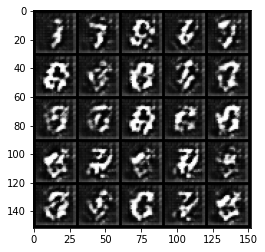

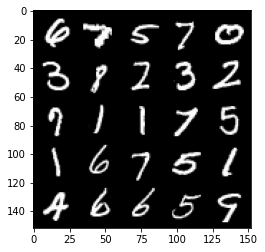

Step 2000: Generator loss: 0.9507988895177848, discriminator loss: 0.5739438167810447


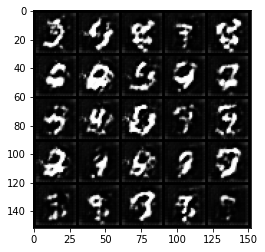

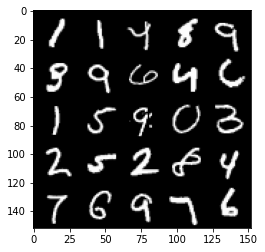

Step 2500: Generator loss: 0.9038791999220844, discriminator loss: 0.5860969262123106


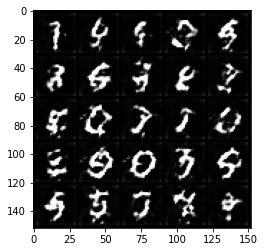

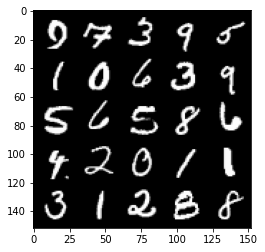

Step 3000: Generator loss: 0.8546109390258783, discriminator loss: 0.6101954852342604


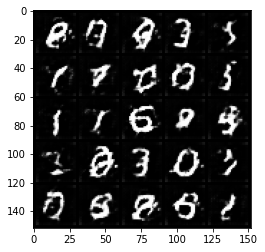

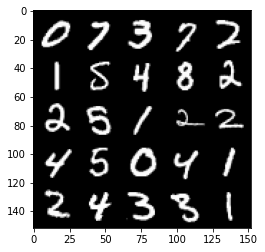

Step 3500: Generator loss: 0.8068474708199499, discriminator loss: 0.6404061950445178


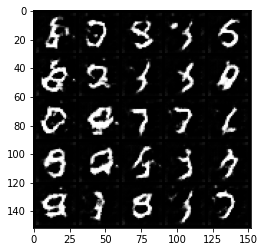

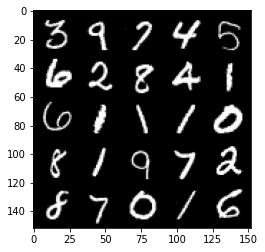

Step 4000: Generator loss: 0.7756476859450335, discriminator loss: 0.6537603201866143


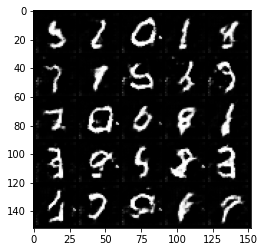

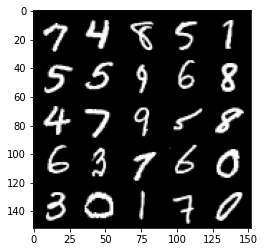

Step 4500: Generator loss: 0.7689847894310953, discriminator loss: 0.6613062239885334


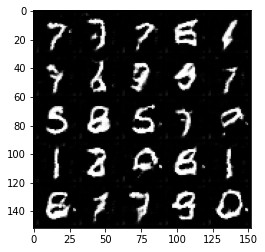

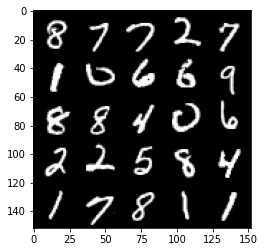

Step 5000: Generator loss: 0.7560472195148469, discriminator loss: 0.6708697006702418


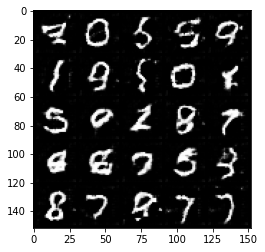

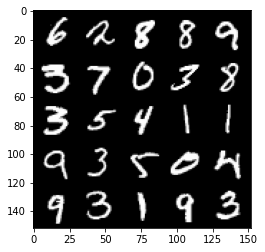

Step 5500: Generator loss: 0.7451619813442232, discriminator loss: 0.6778399593830109


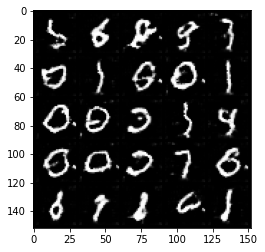

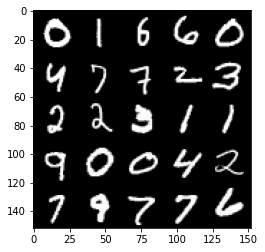

Step 6000: Generator loss: 0.739945200264454, discriminator loss: 0.6809280692338943


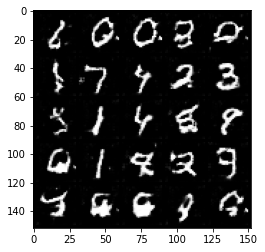

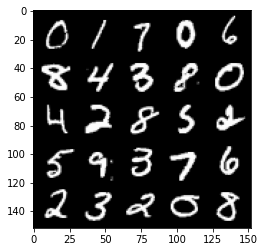

Step 6500: Generator loss: 0.7337541921138772, discriminator loss: 0.6846476686000834


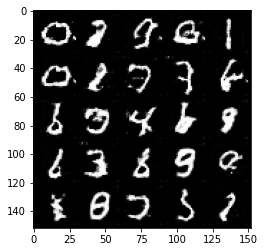

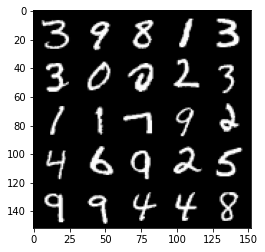

Step 7000: Generator loss: 0.733207655012608, discriminator loss: 0.6860042841434482


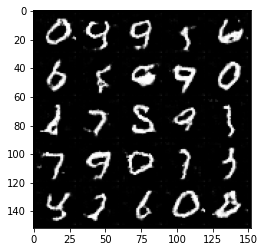

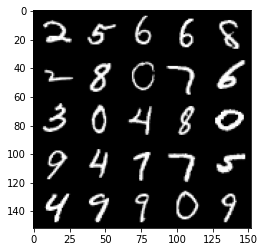

Step 7500: Generator loss: 0.7303242417573937, discriminator loss: 0.6889683961868287


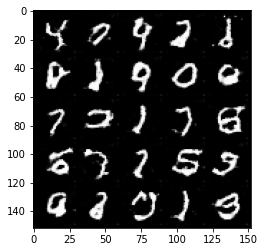

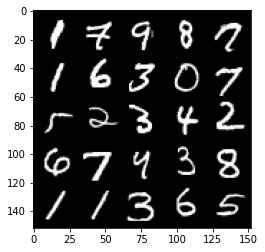

Step 8000: Generator loss: 0.7282954659461973, discriminator loss: 0.6902752343416215


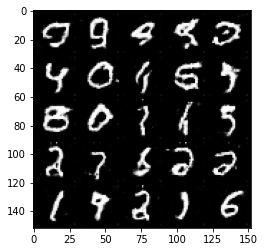

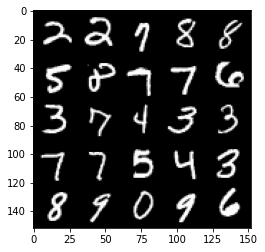

Step 8500: Generator loss: 0.7241711848974223, discriminator loss: 0.6918839179277415


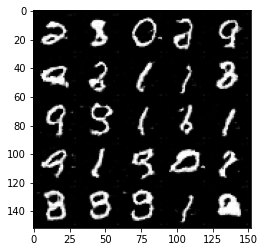

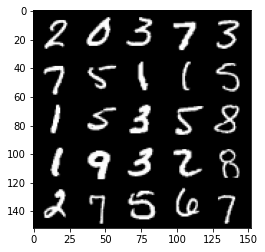

Step 9000: Generator loss: 0.7224336813092224, discriminator loss: 0.6918770914077761


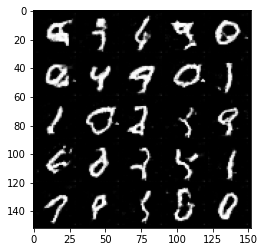

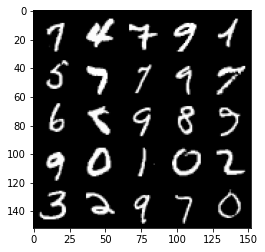

Step 9500: Generator loss: 0.720223478674889, discriminator loss: 0.6932339168787012


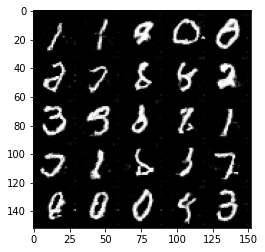

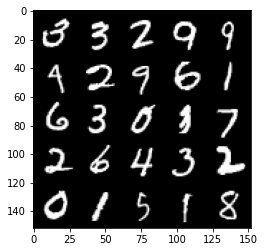

Step 10000: Generator loss: 0.7176769035458562, discriminator loss: 0.6938152811527255


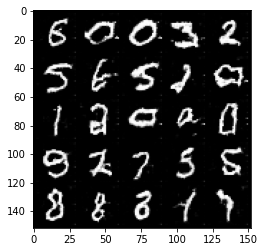

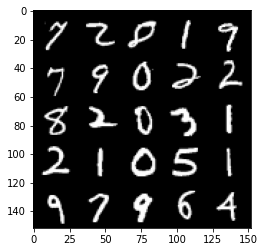

Step 10500: Generator loss: 0.7148149390816689, discriminator loss: 0.6935842013359068


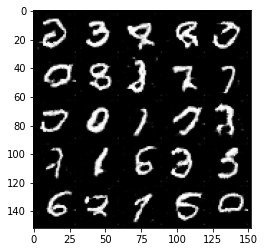

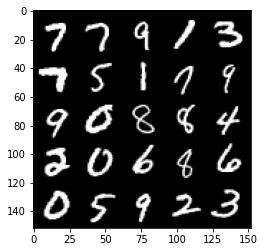

Step 11000: Generator loss: 0.713378398776055, discriminator loss: 0.6944778698682788


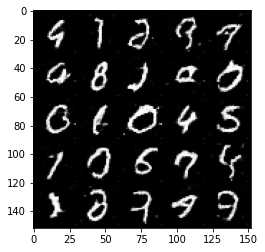

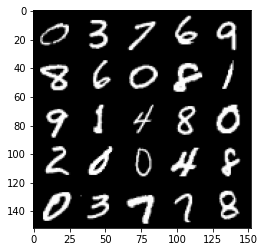

Step 11500: Generator loss: 0.7142614784836762, discriminator loss: 0.6945145186185832


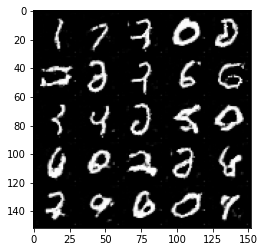

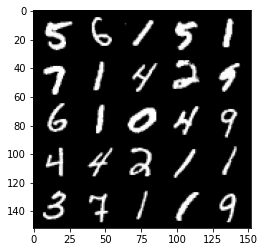

Step 12000: Generator loss: 0.7118233818411819, discriminator loss: 0.6945210499763493


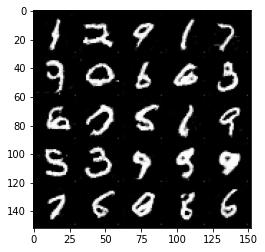

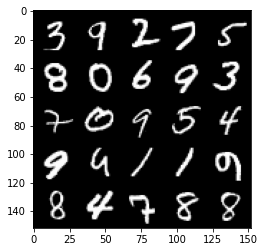

Step 12500: Generator loss: 0.7118348481655123, discriminator loss: 0.6954343951940536


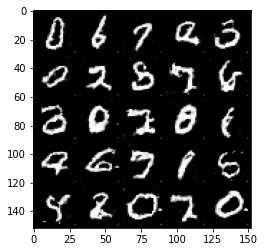

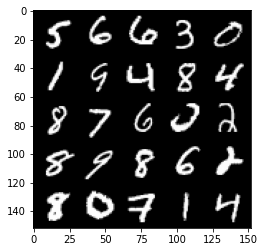

Step 13000: Generator loss: 0.7096280260086058, discriminator loss: 0.694649309754372


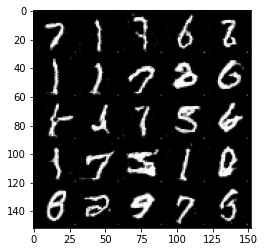

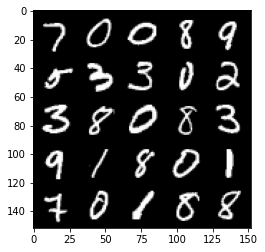

Step 13500: Generator loss: 0.708505843222141, discriminator loss: 0.695173924326897


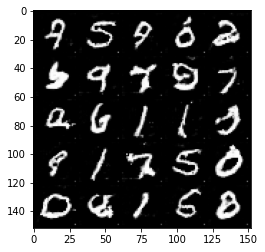

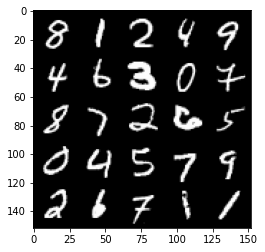

Step 14000: Generator loss: 0.7074978480339063, discriminator loss: 0.6959963623285292


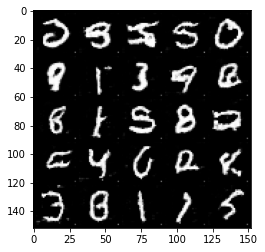

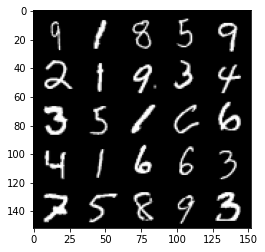

Step 14500: Generator loss: 0.7056576966047289, discriminator loss: 0.6958279561996455


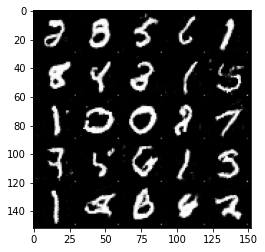

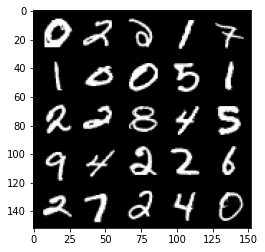

Step 15000: Generator loss: 0.703973811268807, discriminator loss: 0.6962604726552968


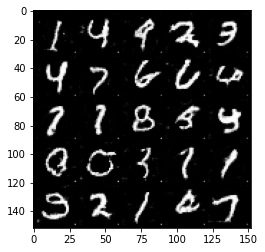

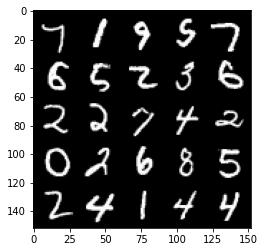

Step 15500: Generator loss: 0.7057405968904497, discriminator loss: 0.6960540411472325


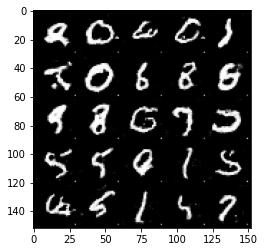

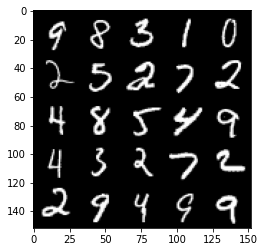

Step 16000: Generator loss: 0.7027044881582273, discriminator loss: 0.6959827136993408


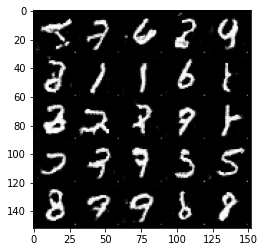

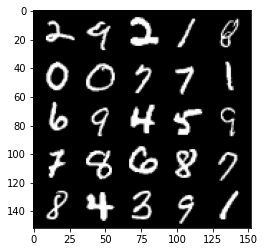

Step 16500: Generator loss: 0.7026852067708975, discriminator loss: 0.6959496765136715


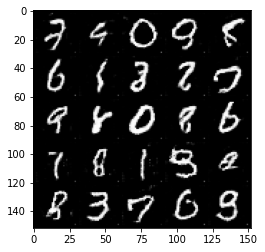

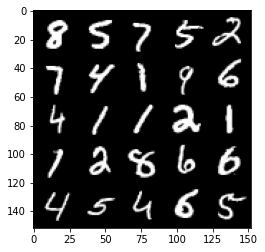

Step 17000: Generator loss: 0.701474022626877, discriminator loss: 0.6970942375659944


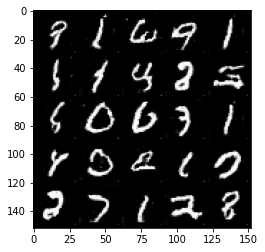

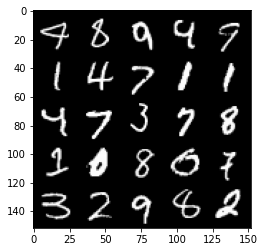

Step 17500: Generator loss: 0.6999647133350375, discriminator loss: 0.6958256505727777


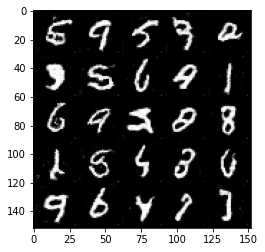

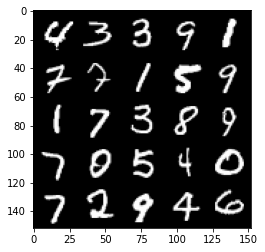

Step 18000: Generator loss: 0.7007789412736892, discriminator loss: 0.695793402791023


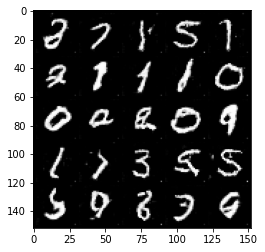

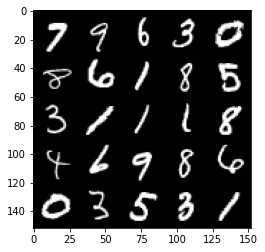

Step 18500: Generator loss: 0.6994908353090282, discriminator loss: 0.6957373199462892


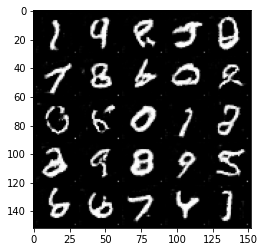

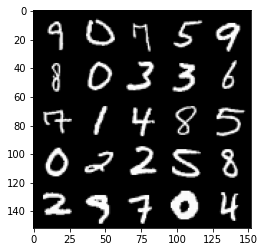

Step 19000: Generator loss: 0.6991320482492454, discriminator loss: 0.6960793808698653


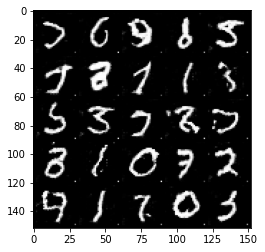

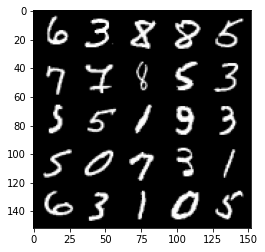

Step 19500: Generator loss: 0.6982221517562875, discriminator loss: 0.6959348846673962


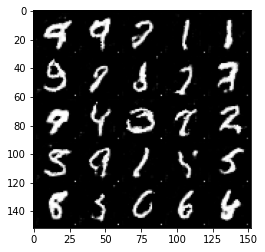

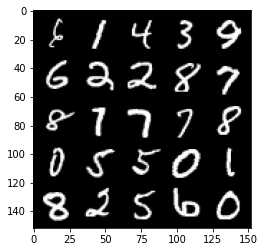

Step 20000: Generator loss: 0.6978710751533503, discriminator loss: 0.6959145932197563


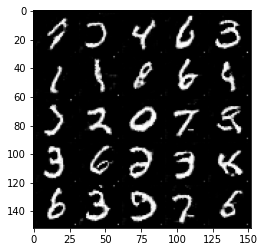

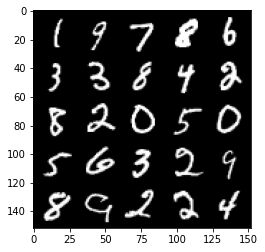

Step 20500: Generator loss: 0.6986059514284141, discriminator loss: 0.6957200422286984


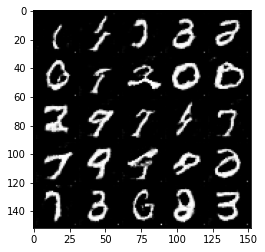

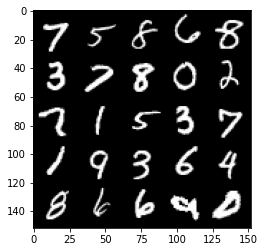

Step 21000: Generator loss: 0.6959596699476247, discriminator loss: 0.6958551751375198


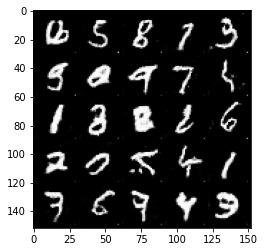

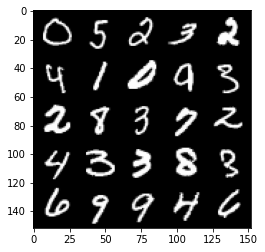

Step 21500: Generator loss: 0.6970554091930392, discriminator loss: 0.6957004779577256


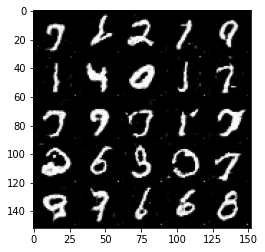

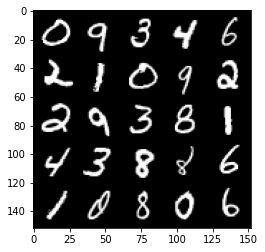

Step 22000: Generator loss: 0.6953884190320968, discriminator loss: 0.6954095085859301


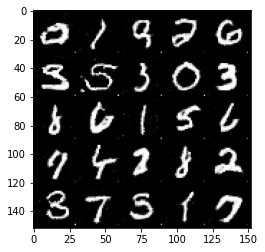

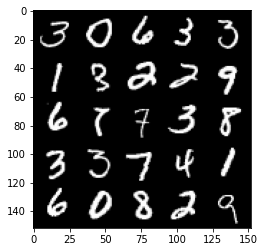

Step 22500: Generator loss: 0.6972286305427545, discriminator loss: 0.6953768674135206


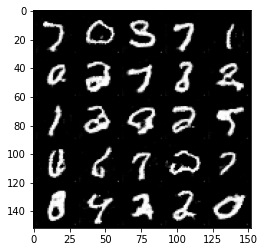

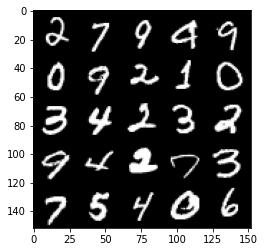

Step 23000: Generator loss: 0.6971629977226257, discriminator loss: 0.6952641558647159


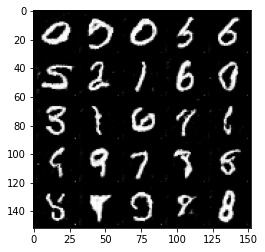

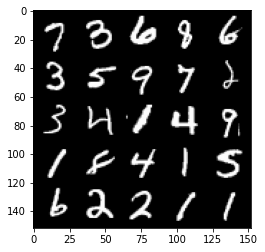

In [11]:
# Training
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
